## Imports

In [2]:

import numpy as np
from numpy.random import default_rng
import wfdb
from scipy import stats
from scipy.stats import linregress
from scipy.signal import butter, filtfilt, find_peaks
import os
import matplotlib.pyplot as plt
from biosppy.signals import ecg

## Desarrollo

### Funciones necesarias

In [3]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [4]:
def estima_hurst(x, min_scale=5, max_scale=None, num_scales=20):
    """
    Estima el exponente de Hurst H usando el método log-log
    (basado en la varianza de la media en bloques).

    Parámetros:
        x (array-like): serie de tiempo (ej. RR intervals)
        min_scale (int): escala mínima (en número de muestras)
        max_scale (int): escala máxima (por defecto: len(x)//4)
        num_scales (int): número de escalas logarítmicas a analizar

    Retorna:
        H (float): estimación del parámetro de Hurst
    """
    x = np.array(x)
    N = len(x)
    
    if max_scale is None:
        max_scale = N // 4
    if max_scale <= min_scale:
        raise ValueError("max_scale debe ser mayor que min_scale")

    # Definir escalas logarítmicas
    scales = np.unique(np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num_scales)).astype(int))
    
    F = []

    for s in scales:
        n_blocks = N // s
        if n_blocks < 2:
            continue
        variances = []
        for i in range(n_blocks):
            segment = x[i * s : (i + 1) * s]
            if len(segment) == 0:
                continue
            var = np.var(segment)
            if var > 0:
                variances.append(var)
        if len(variances) > 0:
            F.append(np.mean(variances))
        else:
            F.append(np.nan)

    # Quitar NaNs
    scales = np.array(scales)
    F = np.array(F)
    valid = ~np.isnan(F)
    log_scales = np.log2(scales[valid])
    log_F = np.log2(F[valid])

    # Ajuste lineal
    coeffs = np.polyfit(log_scales, log_F, 1)
    slope, intercept, r_value, p_value, std_err = linregress(log_scales, log_F)
    H = coeffs[0] / 2  # La pendiente es ≈ 2H
    H2 = slope / 2
    delta_H = std_err / 2
    return H, H2, delta_H

In [5]:
def estimate_hurst_dfa(signal, min_scale=5, max_scale=None, num_scales=20, order=1):
    import numpy as np
    x = np.array(signal, dtype=float)
    N = len(x)
    if max_scale is None:
        max_scale = N // 4
    if max_scale <= min_scale or N < 2 * min_scale:
        raise ValueError("Escala o longitud de señal insuficiente.")

    # Perfil integrado
    x -= np.mean(x)
    y = np.cumsum(x)

    scales = np.unique(np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num_scales)).astype(int))
    F = []

    for s in scales:
        n = N // s
        fluctuations = []
        for i in range(n):
            segment = y[i*s:(i+1)*s]
            t = np.arange(s)
            p = np.polyfit(t, segment, order)
            trend = np.polyval(p, t)
            fluct = np.sqrt(np.mean((segment - trend) ** 2))
            fluctuations.append(fluct)
        F.append(np.mean(fluctuations))

    slope, intercept, r_value, p_value, std_err = linregress(np.log2(scales), np.log2(F))

    coeffs = np.polyfit(np.log2(scales), np.log2(F), 1)
    H = coeffs[0]
    H2 = slope
    delta_H = std_err
    return H, H2, delta_H

In [6]:
%pip install scipy matplotlib
def _pendienteci(x, y):
    """
    Regresión lineal simple (mínimos cuadrados) y cálculo de intervalo de confianza al 95% para la pendiente.

    Parámetros
    ----------
    x : 1D array
        Variable independiente (log10(m)).
    y : 1D array
        Variable dependiente (log10(varianza)).

    Devuelve
    -------
    m : float
        Pendiente de la recta.
    b : float
        Ordenada al origen de la recta.
    ml : float
        Límite inferior de intervalo de confianza (95%) para m.
    mh : float
        Límite superior de intervalo de confianza (95%) para m.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n = x.size
    if n < 3:
        raise ValueError("Se requieren al menos 3 puntos para realizar regresión.")

    # Cálculo de parámetros de la recta: m y b
    A = np.dot(x, x)
    B = x.sum()
    C = np.dot(x, y)

    x_mean = x.mean()
    y_mean = y.mean()

    m = (C - B * y_mean) / (A - B * x_mean)
    b = y_mean - m * x_mean

    # Error residual
    y_pred = m * x + b
    error = y - y_pred
    s = np.sqrt(np.dot(error, error) / (n - 2))

    # Sxx = sum((x - x_mean)^2)
    ex = x - x_mean
    Sxx = np.dot(ex, ex)

    # t critico para 95% en n-2 grados de libertad
    tval = stats.t.ppf(0.975, df=n - 2)

    # Intervalo de confianza para la pendiente m
    ml = m - tval * s / np.sqrt(Sxx)
    mh = m + tval * s / np.sqrt(Sxx)

    return m, b, ml, mh

def vt(traza):
    """
    Diagrama Varianza–Tiempo y estimación del parámetro de Hurst.

    Parámetros
    ----------
    traza : array_like, 1D
        Vector de datos (serie de tiempo) sobre el cual se calcula el diagrama varianza–tiempo.

    Devuelve
    -------
    H     : float
        Estimación del parámetro de Hurst (punto medio de la recta).
    Hmin  : float
        Límite inferior del intervalo de confianza al 95% para H.
    Hmax  : float
        Límite superior del intervalo de confianza al 95% para H.

    Además, la función dibuja (en pantalla) el diagrama log10(varianza) vs. log10(m)
    junto con la recta de regresión lineal y su intervalo de confianza.
    """
    traza = np.asarray(traza).flatten()
    L = traza.size

    # gruposmax = fix(L / sqrt(L)) en MATLAB equivale a floor(sqrt(L))
    gruposmax = int(np.floor(np.sqrt(L)))
    if gruposmax < 2:
        raise ValueError("La longitud de 'traza' es demasiado pequeña para calcular vt().")

    # Reservamos un arreglo para varianza; tendrá longitud (gruposmax - 1)
    varianza = np.zeros(gruposmax - 1, dtype=float)

    # Para cada n = 2 ... gruposmax, calculamos:
    #   columnas = fix(L / n)
    #   datos  = reshape(traza(1 : n*columnas), [n, columnas])
    #   varianza(n-1) = var(promedios), donde promedios = mean(datos) (promedio por columna)
    for idx, n in enumerate(range(2, gruposmax + 1)):
        columnas = int(np.floor(L / n))
        if columnas < 1:
            # si columnas=0, no podemos reshape; salir del bucle
            break

        # Reproducimos reshape(..., [n, columnas]) de MATLAB (que rellena por columnas).
        bloque = traza[: n * columnas]
        datos = bloque.reshape((n, columnas), order='F')

        # promedio de cada columna (dim=0) y varianza muestral (ddof=1)
        promedios = datos.mean(axis=0)
        varianza[idx] = np.var(promedios, ddof=1)

    # Tomamos sólo los índices válidos (en caso de que el bucle se haya roto antes)
    Npts = idx + 1
    varianza = varianza[:Npts]

    # Construimos x = log10(m) para m = 2,3,...,2+Npts-1
    m_vals = np.arange(2, 2 + Npts)
    x = np.log10(m_vals)
    y = np.log10(varianza)

    # Regresión lineal con intervalo de confianza
    m_slope, b_intercept, ml, mh = _pendienteci(x, y)

    H     = m_slope / 2 + 1
    Hmin  = ml / 2 + 1
    Hmax  = mh / 2 + 1

    # --- Visualización del diagrama ---
    # fig, ax = plt.subplots(figsize=(8, 5))
    # # Puntos experimentales
    # ax.plot(x, y, 's', markerfacecolor='b', markeredgecolor='k', label=r'$\log S_{X^{(m)}}^2$')

    # # Recta de regresión: y_hat = m_slope * x + b_intercept
    # y_hat = m_slope * x + b_intercept
    # ax.plot(x, y_hat, 'r', linewidth=2, label='Regresión Lineal')

    # # Intervalo de confianza (líneas punteadas)
    # xmin, xmax = x.min(), x.max()
    # ymin, ymax = y.min(), y.max()

    # # Definimos x1, x2 tal como en MATLAB (0.45 y 0.55 del rango)
    # x1 = xmin + 0.45 * (xmax - xmin)
    # x2 = xmin + 0.55 * (xmax - xmin)
    # y1 = m_slope * x1 + b_intercept
    # y2 = m_slope * x2 + b_intercept

    # # Dibujamos: una línea vertical en x = x1 desde y1 hasta y2, y luego la horizontal en y = y2 de x1 a x2
    # ax.plot([x1, x1, x2], [y1, y2, y2], 'k:', linewidth=2)

    # # Ajustes estéticos
    # ax.set_title('Diagrama Varianza - Tiempo', fontsize=18)
    # ax.set_xlabel(r'$\log m$', fontsize=18)
    # ax.set_ylabel(r'$\log S_{X^{(m)}}^2$', fontsize=18)
    # ax.grid(True)
    # ax.set_xlim(xmin, xmax)
    # delta_y = ymax - ymin
    # ax.set_ylim(ymin - 0.1 * delta_y, ymax + 0.1 * delta_y)
    # ax.tick_params(labelsize=16)
    # ax.legend(loc='best', fontsize=14, frameon=False)
    # fig.patch.set_facecolor('white')

    # plt.show()

    return H, Hmin, Hmax

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Prueba del estimador de Hurst con datos sintéticos

In [7]:
# Código aquí :v

hurst_values = []

rng = default_rng(42)
x = rng.normal(size=4096)
x_cumsum = np.cumsum(x)  # ruido Browniano ~ H = 0.5

H_est = estima_hurst(x_cumsum)
print(f"H estimado (ruido blanco integrado): {H_est:.3f}") # Debería estar cerca de 0.5

TypeError: unsupported format string passed to tuple.__format__

### Lectura de 1 registro

In [14]:
record = wfdb.rdrecord('D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/e0103')

fs = record.fs
signal = record.p_signal[:,0]

# Procesar ECG
filtered_ecg = bandpass_filter(signal, 0.5, 40, fs) # Entre 0.5 y 40 Hz

### Detección picos R

In [15]:
distance = int(0.4 * fs)
peaks, _ = find_peaks(filtered_ecg, distance=distance, height=filtered_ecg.std())

### Intervalos RR

In [8]:
base_path = 'D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/'
all_rr = []

# Recorre solo los archivos .hea realmente presentes
hea_files = sorted(f for f in os.listdir(base_path) if f.endswith('.hea'))
record_names = [os.path.splitext(f)[0] for f in hea_files]  # sin extensión

for rec_id in record_names:
    print("rec_id:", rec_id)
    dat_path = os.path.join(base_path, rec_id + '.dat')
    hea_path = os.path.join(base_path, rec_id + '.hea')

    if not (os.path.exists(hea_path) and os.path.exists(dat_path)):
        print(f'Saltando {rec_id} (no encontrado)')
        continue

    try:
        print(f'Procesando {base_path} - {rec_id}...')
        record = wfdb.rdrecord(base_path + rec_id)

        signal = record.p_signal[:, 0]
        fs = record.fs

        ecg_data = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
        r_peaks = ecg_data['rpeaks']
        filtered_signal = ecg_data['filtered']

        rr = np.diff(r_peaks) / fs
        rr_norm = (rr - np.mean(rr)) / np.std(rr)  # Normalizar RR

        if len(rr_norm) > 50:
            all_rr.append(rr_norm)
        else:
            all_rr.append(None)
    except Exception as e:
        print(f'Error con {rec_id}: {e}')
        all_rr.append(None)


rec_id: e0103
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0103...
rec_id: e0104
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0104...
rec_id: e0105
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0105...
rec_id: e0106
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0106...
rec_id: e0107
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0107...
rec_id: e0108
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0108...
rec_id: e0110
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0110...
rec_id: e0111
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0111...
rec_id: e0112
Procesando D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/ - e0112...
rec_id: e0113
Procesando D:/Documento

### Gráfica

In [10]:
def hurst_graph(hurst_values, hurst_deltas, record_names, title='Estimación de Hurst para cada señal'):
	if len(hurst_values) != len(record_names):
		print(f"hurst_values tiene longitud {len(hurst_values)}, pero se esperaban {len(record_names)}.")
		return

	x = range(1, len(hurst_values) + 1)
	plt.figure(figsize=(10, 5))
	if hurst_deltas is not None and len(hurst_deltas) == len(hurst_values) and any(hurst_deltas):
		plt.errorbar(x, hurst_values, yerr=hurst_deltas, fmt='o', ecolor='gray', capsize=4, label='H ± ΔH')
	else:
		plt.plot(x, hurst_values, 'o', label='H')
	plt.xticks(ticks=x, labels=record_names, rotation=90, fontsize=8)
	plt.xlabel('Archivo')
	plt.ylabel('Hurst (H)')
	plt.title(title)
	plt.grid(True, axis='y')
	plt.tight_layout()
	plt.legend()
	plt.show()


### Aplicar estimador de Hurst

Index: 0
Hurst Log: 0.03794787864493081 H2: 0.03794787864493086 Delta H: 0.0017367405597873906
Hurst VT: 0.8420390641002439 H_min: 0.8359021175770732 H_max: 0.8481760106234145
Hurst DFA: 0.9191667598317569 H22: 0.9191667598317574 Delta H2: 0.01169029032890324
Index: 1
Hurst Log: 0.1304024374092501 H2: 0.13040243740925006 Delta H: 0.004546658277497203
Hurst VT: 0.9776321344092461 H_min: 0.9769955503027542 H_max: 0.978268718515738
Hurst DFA: 1.0938206569460858 H22: 1.0938206569460858 Delta H2: 0.015170917879891659
Index: 2
Hurst Log: 0.13826803245058142 H2: 0.13826803245058128 Delta H: 0.009924282784422103
Hurst VT: 0.8682842928621982 H_min: 0.8619923227516693 H_max: 0.8745762629727272
Hurst DFA: 1.0477303290917248 H22: 1.0477303290917244 Delta H2: 0.018103104705968702
Index: 3
Hurst Log: 0.10615535475517467 H2: 0.10615535475517475 Delta H: 0.005643842703296503
Hurst VT: 0.8745435384609707 H_min: 0.8685321573144318 H_max: 0.8805549196075095
Hurst DFA: 1.0398767617192048 H22: 1.0398767617

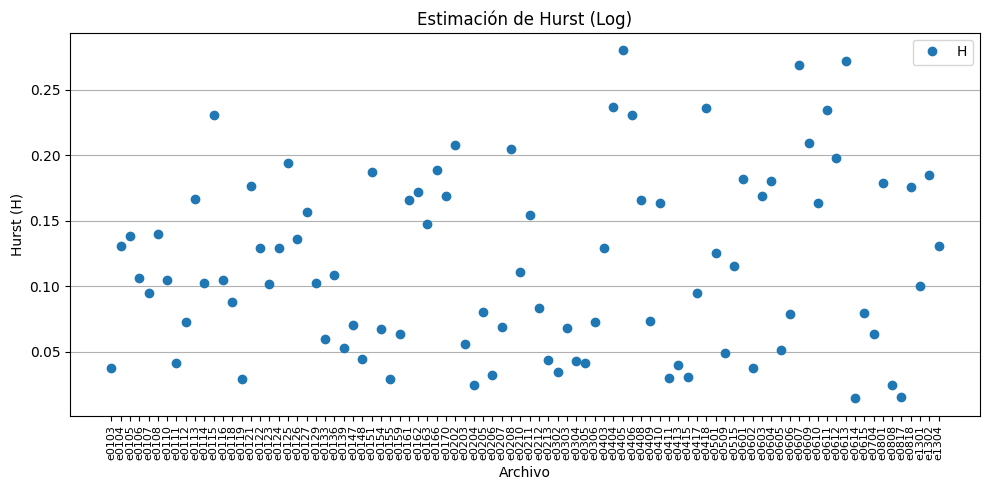

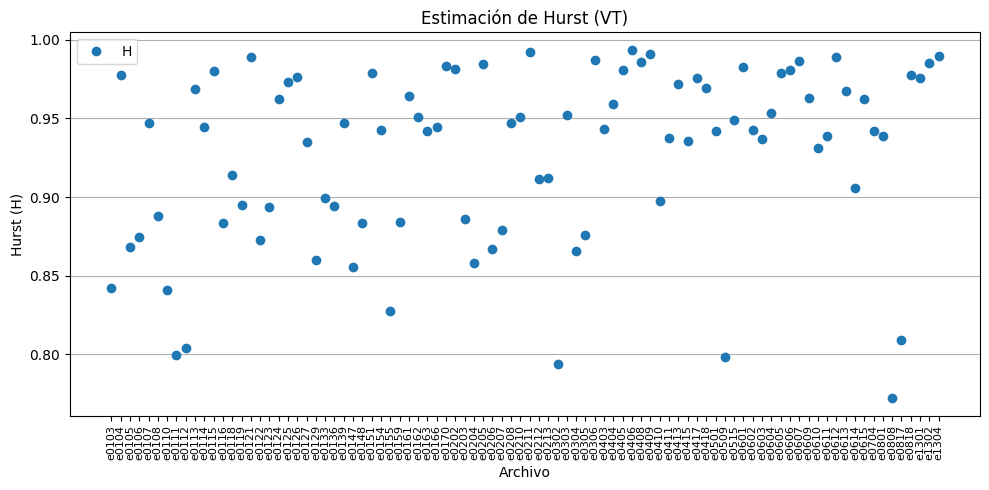

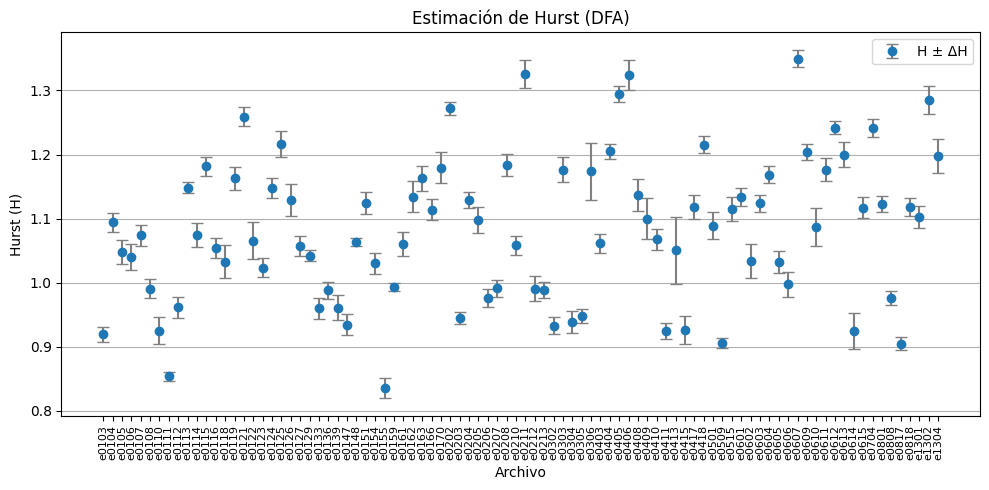

In [11]:
# Código aquí :v

hurst_log = []

hurst_vt = []

hurst_dfa = []
deltas_dfa = []

for idx, rr in enumerate(all_rr):
    print("Index:", idx)
    if rr is None:
        hurst_log.append(np.nan)
        hurst_vt.append(np.nan)
        hurst_dfa.append(np.nan)
    else:
        H_log, H2, delta_H = estima_hurst(rr)
        print("Hurst Log:", H_log, "H2:", H2, "Delta H:", delta_H)
        H_vt, H_min, H_max = vt(rr)
        print("Hurst VT:", H_vt, "H_min:", H_min, "H_max:", H_max)
        H_dfa, H22, delta_H2 = estimate_hurst_dfa(rr)
        print("Hurst DFA:", H_dfa, "H22:", H22, "Delta H2:", delta_H2)
        hurst_log.append(H_log)
        hurst_vt.append(H_vt)
        hurst_dfa.append(H_dfa)
        deltas_dfa.append(delta_H2)
print("Hurst values:", hurst_log)
print("Hurst values VT:", hurst_vt)
print("Hurst values DFA:", hurst_dfa)
hurst_graph(hurst_log, [], record_names, title='Estimación de Hurst (Log)')
hurst_graph(hurst_vt, [], record_names, title='Estimación de Hurst (VT)')
hurst_graph(hurst_dfa, deltas_dfa, record_names, title='Estimación de Hurst (DFA)')

In [25]:
def show_loglog(rr):
    import matplotlib.pyplot as plt
    from scipy.stats import linregress

    x = np.array(rr)
    N = len(x)
    scales = np.unique(np.floor(np.logspace(np.log10(5), np.log10(N//4), 15)).astype(int))
    F = []

    for s in scales:
        n_blocks = N // s
        vars_ = [np.var(x[i*s:(i+1)*s]) for i in range(n_blocks)]
        vars_ = [v for v in vars_ if v > 0]
        if vars_:
            F.append(np.mean(vars_))
        else:
            F.append(np.nan)

    scales = np.array(scales)
    F = np.array(F)
    valid = ~np.isnan(F)

    plt.figure()
    plt.loglog(scales[valid], F[valid], 'o-')
    slope, _, _, _, _ = linregress(np.log2(scales[valid]), np.log2(F[valid]))
    H = slope / 2
    plt.title(f'Log-log plot (pendiente ≈ {slope:.3f}, H ≈ {H:.3f})')
    plt.xlabel('Escala (log2)')
    plt.ylabel('Varianza (log2)')
    plt.grid(True)
    plt.show()

### Gráfica boxplot

C:\Users\Youssef\AppData\Local\Temp\ipykernel_11652\147364030.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,


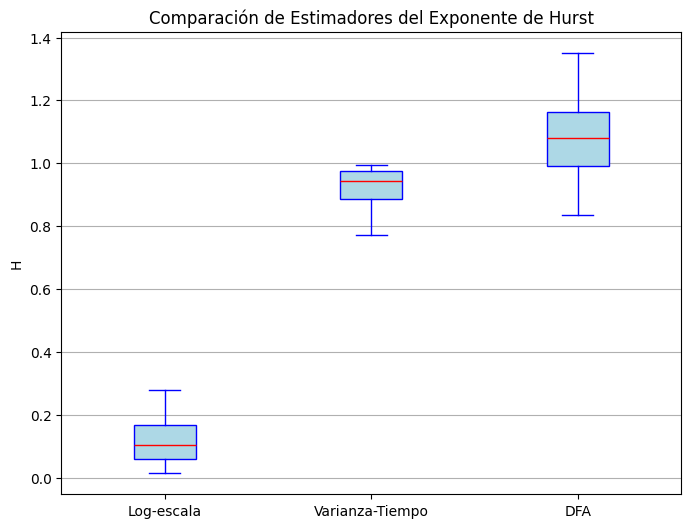

In [15]:
hurst_log_clean = [h for h in hurst_log if h is not None and not np.isnan(h)]
hurst_vt_clean = [h for h in hurst_vt if h is not None and not np.isnan(h)]
hurst_dfa_clean = [h for h in hurst_dfa if h is not None and not np.isnan(h)]

data = [hurst_log_clean, hurst_vt_clean, hurst_dfa_clean]
labels = ['Log-escala', 'Varianza-Tiempo', 'DFA']

# Crear boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data,
            labels=labels,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none', markeredgecolor='gray'))

plt.title('Comparación de Estimadores del Exponente de Hurst')
plt.ylabel('H')
plt.grid(True, axis='y')
plt.show()

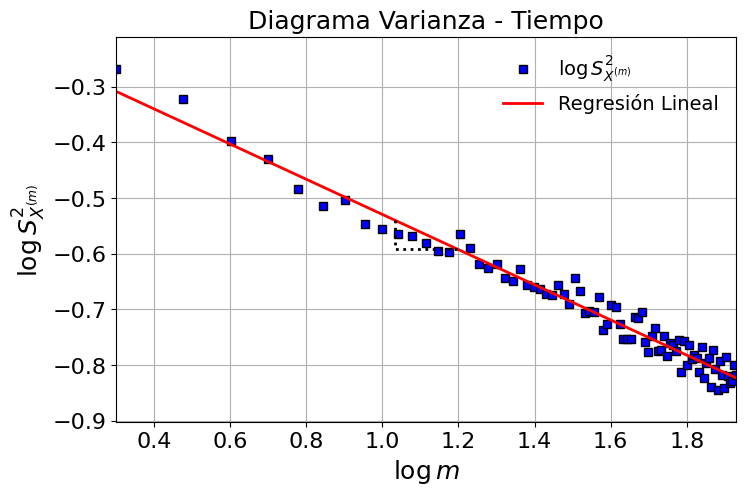

H estimado usando Biosppy: 0.038
H estimado usando DFA: 0.919
H estimado usando VT: 0.842
RR valores (segundos): [0.876 0.932 1.    1.    1.016 0.972 1.036 1.032 0.992 0.956]
Media: 0.9904270776004402   STD: 0.09352181262900358


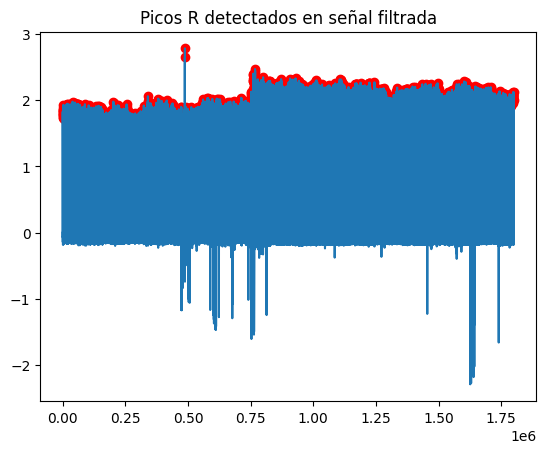

In [71]:
# wfdb.rdann('e0103', 'atr', directory='/ruta')
# record = wfdb.rdrecord('D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/e0103')
record = wfdb.rdrecord('D:/Documentos/UD/Nueva carpeta/FInalHM/LRD_y_multifractales/datos/EDB/e0103')

signal = record.p_signal[:, 0]

# Procesar ECG
fs = record.fs

ecg_data = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
r_peaks = ecg_data['rpeaks']
filtered_signal = ecg_data['filtered']

rr = np.diff(r_peaks) / fs
rr_norm = (rr - np.mean(rr)) / np.std(rr)
H1n1 = estima_hurst(rr_norm)
H_dfa = estimate_hurst_dfa(rr_norm)
H_vt, H_vt_min, H_vt_max = vt(rr_norm)
print(f"H estimado usando Biosppy: {H1n1:.3f}")
print(f"H estimado usando DFA: {H_dfa:.3f}")
print(f"H estimado usando VT: {H_vt:.3f}")
print("RR valores (segundos):", rr[:10])
print("Media:", np.mean(rr), "  STD:", np.std(rr))
plt.plot(filtered_signal)
plt.scatter(r_peaks, filtered_signal[r_peaks], color='red')
plt.title("Picos R detectados en señal filtrada")
plt.show()
# show_loglog(rr_norm)

# Actividad 1

## Prueba de sesgo

## Prueba de robustez

## Prueba de sesgo